## test해볼것
[x] 이진화 한걸로 train  
[ ] 원본+이진화로 train  
    - 데이터 나눠서 이진화 후 원본 훈련 o
    - 데이터 나눠서 원본 후 이진화 훈련
    - 데이터 합쳐서 이진화 후 원본 훈련
    - 데이터 합쳐서 원본 후 이진화 훈련
    - 데이터 랜덤으로
    
    
---
- test 데이터는 2가지 : 원본일때 or 이진화한 test 이미지: 원본으로하기!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

## Python import

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf

from keras import layers
from keras import models
from keras import Input
from keras.models import Model
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from keras.utils import to_categorical
from keras import regularizers # L2규제

from tensorflow.keras.preprocessing.image import ImageDataGenerator # data augmentation
from tensorflow.keras.callbacks import LearningRateScheduler # callbacks 설정

from tqdm.notebook import tqdm # 모델학습 진행 시간 파악
import random # random seed를 뽑을때 사용

#gpu사용
config= tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True

In [25]:
print(tf.__version__)

2.3.0


## Load Data

In [26]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## EDA

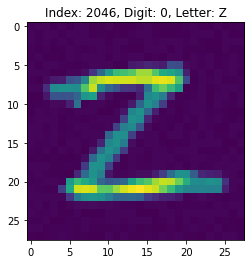

In [27]:
idx = 2046
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

## Train model

In [28]:
x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
x_train = x_train.reshape(-1, 28, 28, 1)
x_edit=x_train
x_train = x_train/255

y = train['digit']
y_train = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    y_train[i, digit] = 1

In [29]:
threshold=140 #임계값
for i in range(0,2048):
    for j in range(0,28):
        for k in range(0,28):
            if(x_edit[i][j][k][0]<=threshold):
                x_edit[i][j][k][0]=0
            else:
                x_edit[i][j][k][0]=255/255

In [30]:
#결과확인
print(x_edit[2046][7])
print(x_train[2046][7])

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
[[0.00784314]
 [0.        ]
 [0.02352941]
 [0.07058824]
 [0.07843137]
 [0.23921569]
 [0.26666667]
 [0.43921569]
 [0.83529412]
 [0.89803922]
 [0.92941176]
 [0.92156863]
 [0.91764706]
 [0.92156863]
 [0.88627451]
 [0.88627451]
 [0.94117647]
 [0.95294118]
 [0.93333333]
 [0.70980392]
 [0.21960784]
 [0.        ]
 [0.01568627]
 [0.00784314]
 [0.01176471]
 [0.        ]
 [0.00392157]
 [0.00784314]]


In [31]:
print(x_train.shape, x_edit.shape)

(2048, 28, 28, 1) (2048, 28, 28, 1)


In [32]:
#concatenate- edit first
c_edit_f=np.r_[x_edit,x_train]

In [33]:
#concatenate- orgin first
c_orgin_f=np.r_[x_train,x_edit]

In [38]:
# concatenate - y
y_train_d=np.r_[y_train,y_train]

In [39]:
y_train_d.shape

(4096, 10)

In [34]:
print(c_edit_f.shape, c_orgin_f.shape)

(4096, 28, 28, 1) (4096, 28, 28, 1)


In [35]:
# 잘 합쳐졌나 확인
print(c_edit_f[2046][7],"\n",c_edit_f[4094][7]) #잘 됨

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]] 
 [[0.00784314]
 [0.        ]
 [0.02352941]
 [0.07058824]
 [0.07843137]
 [0.23921569]
 [0.26666667]
 [0.43921569]
 [0.83529412]
 [0.89803922]
 [0.92941176]
 [0.92156863]
 [0.91764706]
 [0.92156863]
 [0.88627451]
 [0.88627451]
 [0.94117647]
 [0.95294118]
 [0.93333333]
 [0.70980392]
 [0.21960784]
 [0.        ]
 [0.01568627]
 [0.00784314]
 [0.01176471]
 [0.        ]
 [0.00392157]
 [0.00784314]]


In [19]:
c_edit_f1 = np.repeat(c_edit_f, 3, axis=1)
c_edit_f2 = np.repeat(c_edit_f1, 3, axis=2)
c_orgin_f1=np.repeat(c_orgin_f, 3, axis=1)
c_orgin_f2=np.repeat(c_orgin_f1, 3, axis=2)

In [40]:
print(c_edit_f2.shape, c_orgin_f2.shape)

(4096, 84, 84, 1) (4096, 84, 84, 1)


In [21]:
def create_cnn_model():
    inputs = Input(shape = (84,84,1))
    
    bn = tf.keras.layers.BatchNormalization()(inputs)
    conv = tf.keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same', activation='relu')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(64, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)
    
    do=tf.keras.layers.Dropout(0.4)(pool)
    
    bn = tf.keras.layers.BatchNormalization()(do)
    conv = tf.keras.layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    do=tf.keras.layers.Dropout(0.4)(pool)
    
    bn = tf.keras.layers.BatchNormalization()(do)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    flatten = tf.keras.layers.Flatten()(pool)

    bn = tf.keras.layers.BatchNormalization()(flatten)
    dense = tf.keras.layers.Dense(1000, activation='relu')(bn)

    bn = tf.keras.layers.BatchNormalization()(dense)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(bn)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [22]:
create_cnn_model().summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 1)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 84, 84, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 84, 84, 64)        1664      
_________________________________________________________________
batch_normalization_1 (Batch (None, 84, 84, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 84, 84, 64)        16448     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 42, 42, 64)       

In [52]:
#원본 이미지 학습
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1)

model = create_cnn_model() #앞에거에 이어서 학습 할땐 주석처리!
epochs=200

#model.fit(x_train, y_train, epochs=50)

history = model.fit(
  datagen.flow(c_orgin_f2, y_train_d, batch_size=16),
  epochs=epochs, 
  steps_per_epoch = c_orgin_f2.shape[0]//16,
  callbacks=[annealer], 
  verbose = 1
)

Epoch 1/200
256/256 [==============================] - 6s 23ms/step - loss: 3.1320 - accuracy: 0.2744
Epoch 2/200
256/256 [==============================] - 6s 23ms/step - loss: 2.4504 - accuracy: 0.3916
Epoch 3/200
256/256 [==============================] - 6s 22ms/step - loss: 2.3274 - accuracy: 0.4197
Epoch 4/200
256/256 [==============================] - 6s 22ms/step - loss: 2.1467 - accuracy: 0.4590
Epoch 5/200
256/256 [==============================] - 6s 22ms/step - loss: 1.9345 - accuracy: 0.5044
Epoch 6/200
256/256 [==============================] - 6s 22ms/step - loss: 1.8593 - accuracy: 0.5149
Epoch 7/200
256/256 [==============================] - 6s 22ms/step - loss: 1.7096 - accuracy: 0.5552
Epoch 8/200
256/256 [==============================] - 6s 22ms/step - loss: 1.6469 - accuracy: 0.5608
Epoch 9/200
256/256 [==============================] - 6s 22ms/step - loss: 1.5584 - accuracy: 0.5806
Epoch 10/200
256/256 [==============================] - 6s 22ms/step - loss: 1.436

256/256 [==============================] - 6s 23ms/step - loss: 0.3305 - accuracy: 0.9219
Epoch 79/200
256/256 [==============================] - 6s 23ms/step - loss: 0.3239 - accuracy: 0.9202
Epoch 80/200
256/256 [==============================] - 6s 23ms/step - loss: 0.3262 - accuracy: 0.9214
Epoch 81/200
256/256 [==============================] - 6s 22ms/step - loss: 0.3325 - accuracy: 0.9211
Epoch 82/200
256/256 [==============================] - 6s 22ms/step - loss: 0.3226 - accuracy: 0.9241
Epoch 83/200
256/256 [==============================] - 6s 22ms/step - loss: 0.3216 - accuracy: 0.9282
Epoch 84/200
256/256 [==============================] - 6s 22ms/step - loss: 0.3249 - accuracy: 0.9197
Epoch 85/200
256/256 [==============================] - 6s 22ms/step - loss: 0.3239 - accuracy: 0.9248
Epoch 86/200
256/256 [==============================] - 6s 22ms/step - loss: 0.3198 - accuracy: 0.9277
Epoch 87/200
256/256 [==============================] - 6s 22ms/step - loss: 0.3139 - 

## Predict

In [53]:
x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1)
x_t_edit=x_test
x_test = x_test/255

In [54]:
x_test1 = np.repeat(x_test, 3, axis=1)
x_test2 = np.repeat(x_test1, 3, axis=2)

In [55]:
submission = pd.read_csv('data/submission.csv')
submission['digit'] = np.argmax(model.predict(x_test2), axis=1)
submission.head(50)

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
5,2054,9
6,2055,5
7,2056,3
8,2057,4
9,2058,4


In [56]:
submission.to_csv('원본+이진화 합쳐서 훈련_이진화xtest.csv', index=False)

---

In [45]:
threshold=140 #임계값
for i in range(0,20480):
    if(i%3000==0):
        print(i)
    for j in range(0,28):
        for k in range(0,28): 
            if(x_t_edit[i][j][k][0]<=threshold):
                x_t_edit[i][j][k][0]=0
            else:
                x_t_edit[i][j][k][0]=255/255

0
3000
6000
9000
12000
15000
18000


In [46]:
x_t_edit1 = np.repeat(x_t_edit, 3, axis=1)
x_t_edit2 = np.repeat(x_t_edit1, 3, axis=2)

In [47]:
submission2 = pd.read_csv('data/submission.csv')
submission2['digit'] = np.argmax(model.predict(x_t_edit2), axis=1)
submission2.head(50)

,id,digit
0,2049,2
1,2050,0
2,2051,3
3,2052,0
4,2053,3
5,2054,9
6,2055,5
7,2056,3
8,2057,4
9,2058,4


# 저장하기전 head확인하고 아래실행

---

---

---

---

---

---

In [99]:
#head만봐도 정확도가 너무 안좋아서 따로 저장 안하는게 나을듯?
submission2.to_csv('원본-이진화 두 번 이어서 훈련_이진화otest.csv', index=False)